# Functions

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import os
%matplotlib inline

In [15]:
dt = 0.001
tot = 100
Taxis = np.arange(0,tot,dt)
# OU ; input
tau = 1
D = 1
OU=np.zeros(len(Taxis))
mu, sigma = 0, 1
for i in range(len(Taxis)-1):
    OU[i+1]=OU[i]*(1-dt/tau)+np.sqrt(D*dt)*np.random.normal(mu,sigma)
# filtering for OUSmoothed
Fc = 1
b, a = signal.butter(2, 2*Fc*dt, btype='low', analog=False)
LPOU = signal.filtfilt(b, a, OU)
x = LPOU

# Change mean Intensity

In [16]:
C_tau_y = 0.025 #s
C_tau_z = 0.25 #s
gamma = 0.7
I = np.zeros_like(x)
Ttemp = np.arange(0,int(C_tau_y/dt*15))*dt
C_Ky = Ttemp/C_tau_y /C_tau_y *np.exp(-Ttemp/C_tau_y)
Ttemp = np.arange(0,int(min(C_tau_z/dt*8,len(I)/2)))*dt
C_Kz = gamma*Ttemp/C_tau_y /C_tau_y *np.exp(-Ttemp/C_tau_y)+(1-gamma)*Ttemp/C_tau_z /C_tau_z *np.exp(-Ttemp/C_tau_z)

In [17]:
x = (x-np.mean(x))/np.std(x)*0.2+1 #basis: mean = 1, std = 0.2
sy = np.convolve(x, C_Ky, 'full')[:len(x)]*dt
sz = np.convolve(x, C_Kz, 'full')[:len(x)]*dt

In [18]:
alpha = 20. #1/sec
beta =  1.2
K = 23.
g = 40.
phi = 1

alpha_c = -1
alpha_h = g*K
test = 1
tau_c = 1/alpha
tau_h = 1/beta
beta_c = 0.02
beta_h = 20
cone_list = []
horizontal_list = []
s1_list = []

Lum_list = 10**np.arange(-1,4,0.5)
for Lum in Lum_list:
    s1 = sy*Lum
    s2 = sz*Lum
    cone = np.zeros(len(Taxis))
    horizontal = np.zeros(len(Taxis))
    for j in range(len(Taxis)-1):
        dc = dt*(-(1+beta_c*s2[j])*(cone[j]/tau_c+test*horizontal[j]) + alpha_c*s1[j])
        dh = dt*(-(1+beta_h*cone[j])*horizontal[j]/tau_h + alpha_h*cone[j])
        cone[j+1] = cone[j]+dc
        horizontal[j+1] = horizontal[j]+dh
    cone_list.append(cone.copy())
    horizontal_list.append(horizontal.copy())

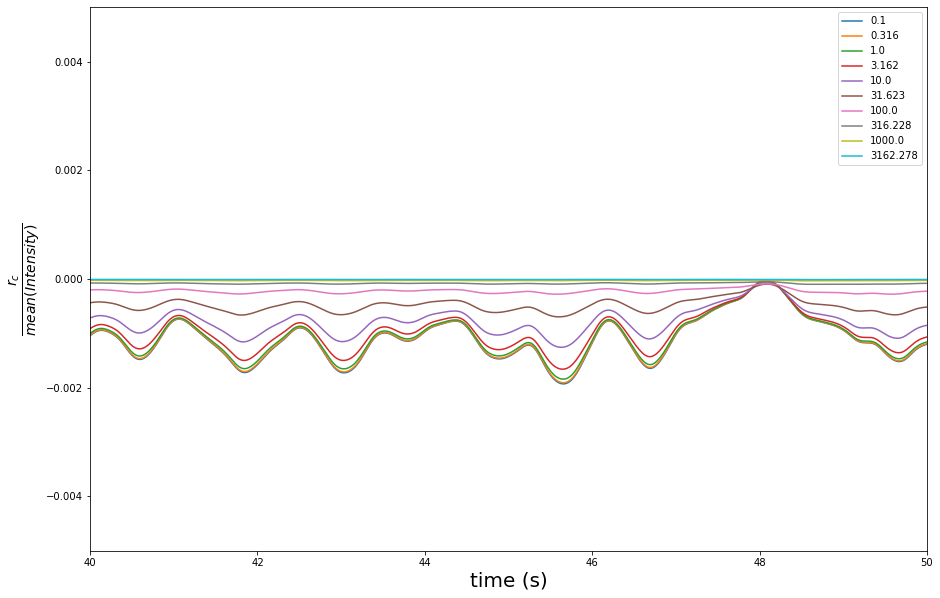

In [19]:
# plt.plot(x*alpha_c)
# plt.plot(sy*alpha_c)
for L in range(len(Lum_list)):
    plt.plot(Taxis, cone_list[L]/Lum_list[L], label = str(round(Lum_list[L], 3)))
plt.ylabel(r'$\frac{r_c}{mean(Intensity)}$', fontsize = 20)
plt.xlabel('time (s)', fontsize = 20)
plt.xlim([40, 50])
plt.ylim([-0.005, 0.005])
# plt.ylim([-0.05, 0.])
plt.legend(loc='best')
plt.gcf().set_size_inches(15, 10)

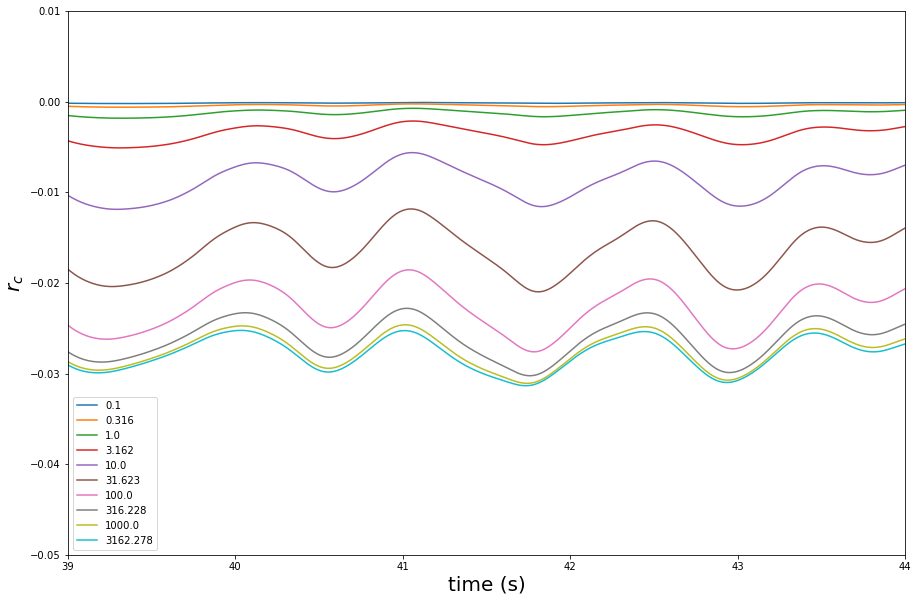

In [20]:
# plt.plot(x*alpha_c)
# plt.plot(sy*alpha_c)
for L in range(len(Lum_list)):
    plt.plot(Taxis, cone_list[L], label = str(round(Lum_list[L], 3)))
plt.ylabel(r'$r_c$', fontsize = 20)
plt.xlabel('time (s)', fontsize = 20)
plt.xlim([39, 44])
# plt.ylim([-0.005, 0.005])
plt.ylim([-0.05, 0.01])
plt.legend(loc='best')
plt.gcf().set_size_inches(15, 10)

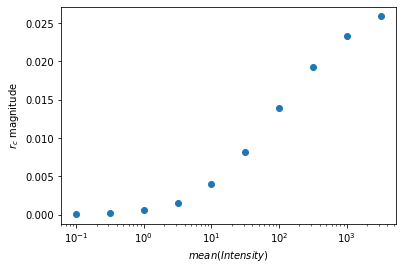

In [21]:
plt.scatter(Lum_list, np.std(np.array(cone_list), axis = 1), label = str(round(Lum_list[L], 3)))
plt.ylabel(r'$r_c$ magnitude')
plt.xlabel(r'$mean(Intensity)$')
plt.xscale('log')

In [22]:
baseXcor_list = [np.correlate(cone_list[0], cone, 'same')/np.std(cone) for cone in cone_list]
Xc_maxidex = [np.argmax(Xcor) for Xcor in baseXcor_list]
autoCenter = Xc_maxidex[0]
b_preceding = (np.array(Xc_maxidex) - Xc_maxidex[0])*dt

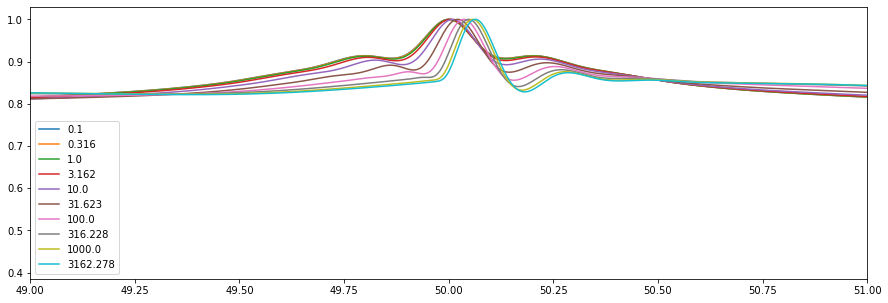

In [23]:
for L in range(len(Lum_list)):
    plt.plot(Taxis, baseXcor_list[L]/max(baseXcor_list[L]), label = str(round(Lum_list[L], 3)))
plt.legend()
plt.xlim([49, 51])
plt.gcf().set_size_inches(15, 5)

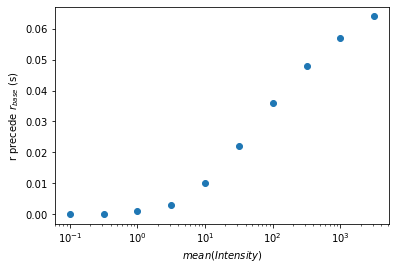

In [24]:
plt.scatter(Lum_list, b_preceding)
plt.ylabel(r'r precede $r_{base}$ (s)')
plt.xlabel(r'$mean(Intensity)$')
plt.xscale('log')

In [25]:
xXcor_list = [np.correlate(x-1, cone, 'same')/np.std(cone) for cone in cone_list]
# xXcor_list = [np.correlate(x-1, cone_list[L], 'same')/np.correlate(np.ones_like(x), cone_list[L], 'same') for L in range(len(Lum_list))]

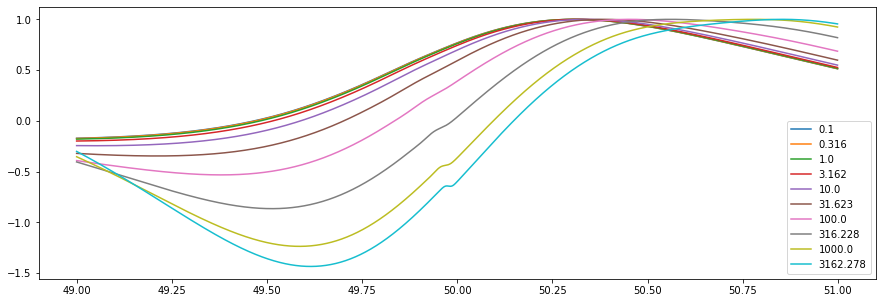

In [26]:
centerregion =  np.arange(49000, 51000)
Xc_maxidex = [np.argmin(Xcor[centerregion]) for Xcor in xXcor_list]
x_preceding = (np.array(Xc_maxidex)+centerregion[0] - autoCenter)*dt

for L in range(len(Lum_list)):
    Yinplot = xXcor_list[L][centerregion]/min(xXcor_list[L][centerregion])
    plt.plot(Taxis[centerregion], Yinplot, label = str(round(Lum_list[L], 3)))
plt.legend()
plt.gcf().set_size_inches(15, 5)

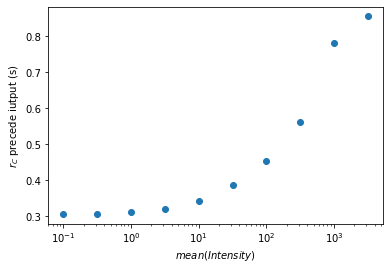

In [27]:
plt.scatter(Lum_list, x_preceding, label = str(round(Lum_list[L], 3)))
plt.ylabel(r'$r_C$ precede iutput (s)')
plt.xlabel(r'$mean(Intensity)$')
plt.xscale('log')

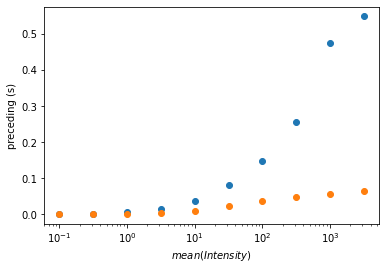

In [28]:
plt.scatter(Lum_list, x_preceding-x_preceding[0], label = 'vs. input (-'+str(x_preceding[0])+'s)')
plt.scatter(Lum_list, b_preceding, label = r'vs. $r_{base}$')
plt.ylabel('preceding (s)')
plt.xlabel(r'$mean(Intensity)$')
plt.xscale('log')

# Change Contrast

In [29]:
alpha = 20. #1/sec
beta =  1.2
K = 23.
g = 40.
phi = 1

alpha_c = -1
alpha_h = g*K
test = 1
tau_c = 1/alpha
tau_h = 1/beta
beta_c = 0.02
beta_h = 20
cone_list = []
horizontal_list = []
s1_list = []

Con_list = np.linspace(0.03, 0.3, 10)
Lum = 100
for con in Con_list:
    xCon = ((x-np.mean(x))/np.std(x)*con+1)*Lum #basis: mean = 1, std = 0.2
    s1 = np.convolve(xCon, C_Ky, 'full')[:len(x)]*dt
    s2 = np.convolve(xCon, C_Kz, 'full')[:len(x)]*dt

    cone = np.zeros(len(Taxis))
    horizontal = np.zeros(len(Taxis))
    for j in range(len(Taxis)-1):
        dc = dt*(-(1+beta_c*s2[j])*(cone[j]/tau_c+test*horizontal[j]) + alpha_c*s1[j])
        dh = dt*(-(1+beta_h*cone[j])*horizontal[j]/tau_h + alpha_h*cone[j])
        cone[j+1] = cone[j]+dc
        horizontal[j+1] = horizontal[j]+dh
    cone_list.append(cone.copy())
    horizontal_list.append(horizontal.copy())

In [30]:
# for con in Con_list:
#     s1 = (((sy-1)*5*con)+1) *Lum
#     plt.plot(Taxis, s1, label = str(round(con,3)))
# plt.xlim([40, 50])
# # plt.ylim([-0.03, -0.015])
# plt.legend(loc='best')
# plt.gcf().set_size_inches(15, 10)

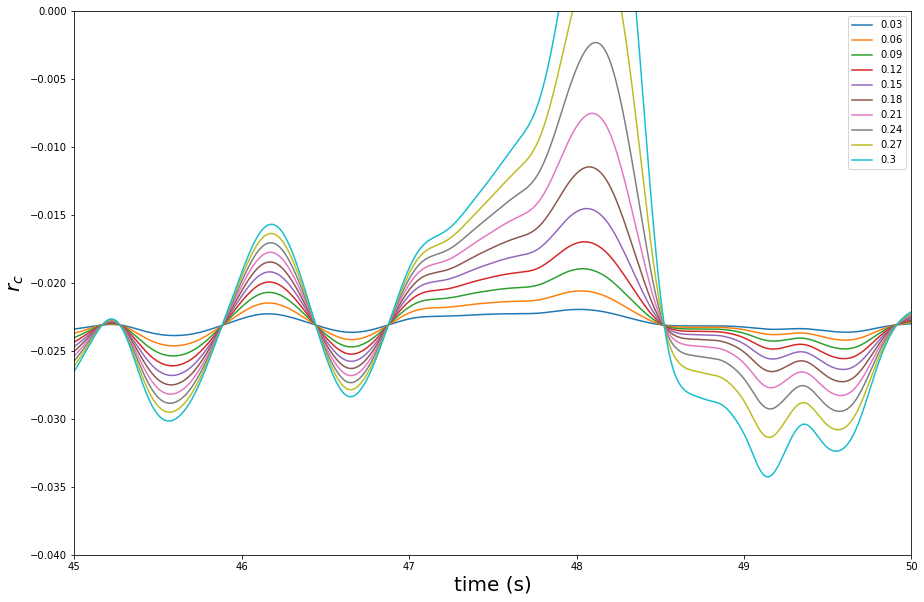

In [31]:
# plt.plot(x*alpha_c)
# plt.plot(sy*alpha_c)
for C in range(len(Con_list)):
    plt.plot(Taxis, cone_list[C], label = str(round(Con_list[C],3)))
plt.ylabel(r'$r_c$', fontsize = 20)
plt.xlabel('time (s)', fontsize = 20)
plt.xlim([45, 50])
plt.ylim([-0.04, -0.0])
# plt.ylim([-0.05, 0.])
plt.legend(loc='best')
plt.gcf().set_size_inches(15, 10)

Text(0.5, 0, 'Contrast ($\\frac{dI}{I}$)')

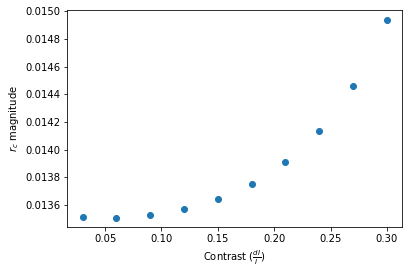

In [32]:
plt.scatter(Con_list, np.std(np.array(cone_list), axis = 1))
plt.ylabel(r'$r_c$ magnitude')
plt.xlabel(r'Contrast ($\frac{dI}{I}$)')
# plt.xscale('log')

In [33]:
baseXcor_list = [np.correlate(cone_list[0], cone_list[L], 'same')/np.std(cone_list[L]) for L in range(len(Con_list))]
Xc_maxidex = [np.argmax(Xcor) for Xcor in baseXcor_list]
autoCenter = Xc_maxidex[0]
b_preceding = (np.array(Xc_maxidex) - Xc_maxidex[0])*dt

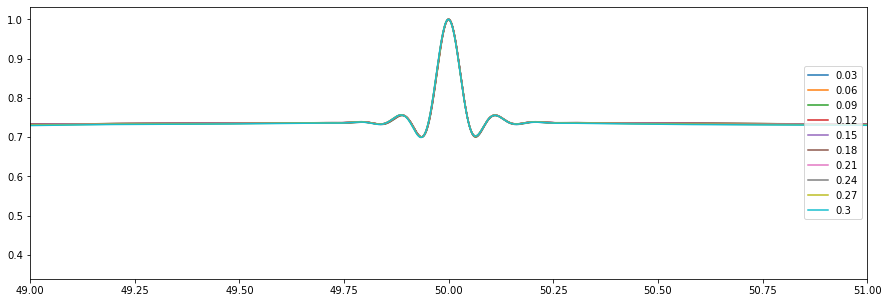

In [34]:
for L in range(len(Con_list)):
    plt.plot(Taxis, baseXcor_list[L]/max(baseXcor_list[L]), label = str(round(Con_list[L],3)))
plt.xlim([49, 51])
plt.legend(loc = 'right')
plt.gcf().set_size_inches(15, 5)

Text(0.5, 0, 'contrast')

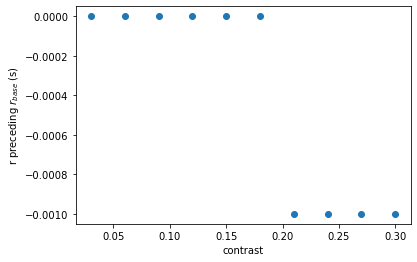

In [35]:
plt.scatter(Con_list, b_preceding)
plt.ylabel(r'r preceding $r_{base}$ (s)')
plt.xlabel('contrast')
# plt.xscale('log')

In [36]:
xXcor_list = [np.correlate(x-1, cone_list[L], 'same')/np.std(cone_list[L]) for L in range(len(Con_list))]
# xXcor_list = [np.correlate(x-1, cone_list[L], 'same')/np.correlate(np.ones_like(x), cone_list[L], 'same') for L in range(len(Lum_list))]

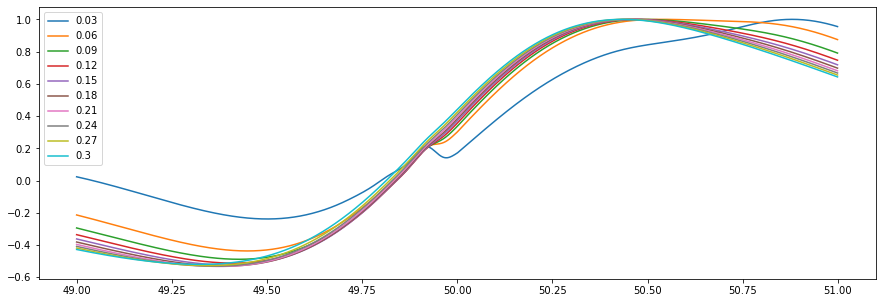

In [37]:
centerregion =  np.arange(49000, 51000)
Xc_maxidex = [np.argmin(Xcor[centerregion]) for Xcor in xXcor_list]
x_preceding = (np.array(Xc_maxidex)+centerregion[0] - autoCenter)*dt

for L in range(len(Con_list)):
    Yinplot = xXcor_list[L][centerregion]/min(xXcor_list[L][centerregion])
    plt.plot(Taxis[centerregion], Yinplot, label = str(round(Con_list[L],3)))
plt.legend()
plt.gcf().set_size_inches(15, 5)

Text(0.5, 0, 'contrast')

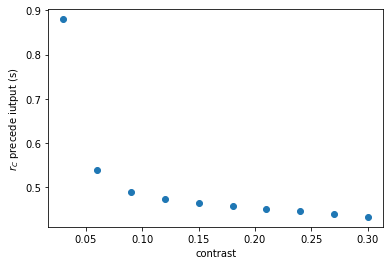

In [38]:
plt.scatter(Con_list, x_preceding)
plt.ylabel(r'$r_C$ precede iutput (s)')
plt.xlabel('contrast')
# plt.xscale('log')

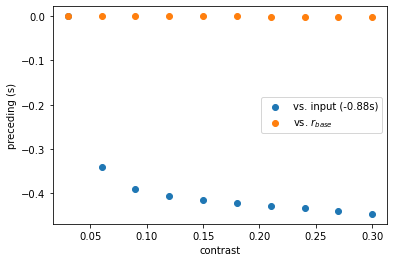

In [39]:
plt.scatter(Con_list, x_preceding-x_preceding[0], label = 'vs. input (-'+str(x_preceding[0])+'s)')
plt.scatter(Con_list, b_preceding, label = r'vs. $r_{base}$')
plt.ylabel('preceding (s)')
plt.xlabel('contrast')
# plt.xscale('log')
plt.legend()